# Tarea 2 : Kart electrico
## Special thanks to : Mariana Cordoba & David Clavijo

Mariana: Todo
Clavijo : F. de T

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from scipy.integrate import trapz

In [7]:
# Datos Kart general
masa=152.0 # masa del Kart (kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Dimensione del kart
t2cm=0.2231 # Distancia del centro de gravedad al eje de la llanta trasera (m)
t2f=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.07478 # Altura del centro de gravedad del kart con respecto al piso (m)


# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=19.0 # Dientes del piñon del motor
dpl=10.0 # Dientes del piñon del eje de salida
etaf=0.95 # Eficiencia de transmisión

# Inercias

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)

paso=7.62 #(mm)
rpim= paso*(0.6+(1/np.tan(180/dp))) # Radio Piñon (mm)
rplam=paso*(0.6+(1/np.tan(180/dpl))) # Radio Plato (mm)
rpi= rpim/1000 #Radio Piñon (m)
rpla= rplam/1000 #Radio Plato (m)
rpi=0.01525#(m)
rpla=0.04096 #(m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.02 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)

itrasmision=((mpi*(rpi**2))/2.0)+((mpla*(rpla**2))/2.0) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2.0 # Inercia del eje de las llantas (kg-m^2)

imotor = 52 * 10^-4 # Inercia del eje del motor (kg-m^2)


# Datos Fuerzas de arrastre
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

#Datos Fuerza de rodadura
f_0 = 0.01 #Basic coefficient (Pg. 118) (Depende de presión de llantas)
f_s = 0.005 #Speed coefficient (Pg. 118) (Depende de presión de llantas)


vector_tm = []
vector_vlts= []
vector_mv= []
vector_ng=[]
vector_acl=[]

In [8]:
for ind in range(1,8):
    ng = ind*0.5
    
    #Calculo de mas rotacional
    mrotacional = ((ieje + itrasmision)* ng**2 + ieje + 2*illt)/rll**2

    # Función de arrastre
    def farrastre(vx):

        if vx>5000*np.pi*rll/(30*ng):
            vx =  5000*np.pi*rll/(30*ng)       

        return (1.0/2.0)*rho*af*cd*(vx+vw)**2 # (N)


    #Función de rodadura (Pg. 111-118)
    def frodadura(v):

        if v> 5000*np.pi*rll/(30*ng):
            v = 5000*np.pi*rll/(30*ng)


        fr= f_0 + 3.24*f_s*(v*2.237/100.0)**(2.5) # Factor de rodadura la velocidad del kart debe estar en (m/s) ()
        return w*fr

    #Función de torque (Clavijo) (Al fin el torque de estos motores no es constante?)
    def torque(v):

        omega = v*ng/(rll)
        omega_rpm = omega*30/np.pi

        if omega_rpm>5000:
            omega_rpm = 5000


        if omega_rpm<100 :
            tq =13
        else:
            #tq= (0.0000001*(omega_rpm**3) - 0.0014* (omega_rpm**2) + 4.6462*omega_rpm +167.42)/omega
            tq= (-0.00000005*(omega_rpm**3) + 0.0001* (omega_rpm**2) + 1.5257*omega_rpm - 12.96)/omega #Clavijo omega_rpm<100 ----> tq = 13
            #tq = -0.00000000001*omega_rpm**3-0.000005*omega_rpm**2+0.0237*omega_rpm+7.8 # omega_rpm<1000 ----> tq=20

        return tq

    #funcion para calcular potenciadef potencia(v):
        omega = v*ng/(rll)
        pt = torque(v)*omega

        return pt

    #Función cinemática de aceleracion
    def funct(t,v):
        ans = ((torque(v)*ng*etaf)/rll - frodadura(v)- farrastre(v))/(masa + mrotacional)
        return ans

    #Función cinemática de desaceleracion
    def funct_2(t,v):
        if v > 0.1:
            ans = (-17/refc - frodadura(v)- farrastre(v))/(masa + mrotacional)
        else:
            ans=0

        return ans

    def drv(t,v):
        llegada = False

        i=0
        while llegada == False & i < len(v)-2 :
            dt = t[i+1] - t[i]
            dx = v[i+1] - v[i]
            dxdt = dx/dt

            if round(dxdt,1) ==0:
                llegada = True

            i= i+1

        return i


    def cuandoparo(v):
        v = np.array(v)
        yp = v<0.1
        ans = sum(yp)

        return ans

    ## Método que soluciona toda la trayectoria
    def calc():
        t_f = 100
        dt=0.1
        y_0 , t_0 = 0 , 0
        r = ode(funct).set_integrator('dopri5')
        r.set_initial_value(y_0,t_0)
        tm=[]
        vlt=[]
        while r.successful() and r.t < t_f:
            tm.append(r.t+dt)
            vlt.append(r.integrate(r.t+dt)[0])
        
        
        fk = drv(tm,vlt)
        vlt= vlt[:fk]
        tm = tm[:fk]
        vint2 = vlt[-2]
        tint2 = tm[-1]+dt
        
        rel = vint2/tint2

        #-------0--------------------0---------------------


        t_fb = 25 + tint2 
        dtb=0.1
        y_0b , t_0b = vint2 , tint2
        rb = ode(funct_2).set_integrator('dopri5')
        rb.set_initial_value(y_0b,t_0b)
        tmb=[]
        vltb=[]
        while rb.successful() and rb.t < t_fb:
            tm.append(rb.t+dtb)
            vlt.append(rb.integrate(rb.t+dtb)[0])


        pare  = cuandoparo(vlt)
        vlt = vlt[:len(vlt)-pare]
        tm = tm[:len(tm)-pare]


        mv =[0]

        for k in range(1,int(tm[-1]/dt)-1):
            a = trapz(vlt[k:k+2],x= None,dx=0.1)
            d = mv[k-1]+a
            mv.append(d)

        ans = [tm,vlt,mv,rel]

        return ans
    
    a,b,c,d= calc()
    vector_tm.append(a)
    vector_vlts.append(b)
    vector_mv.append(c)
    vector_ng.append(str(ng))
    vector_acl.append(d)

tm
    


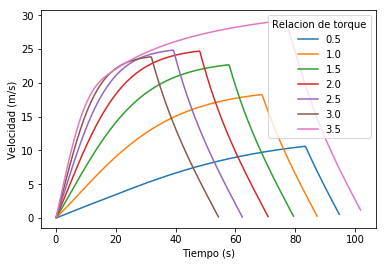

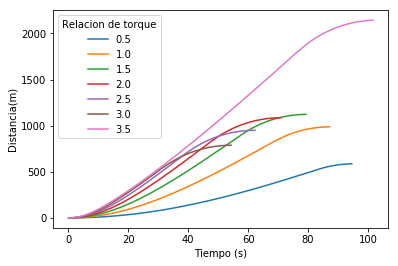

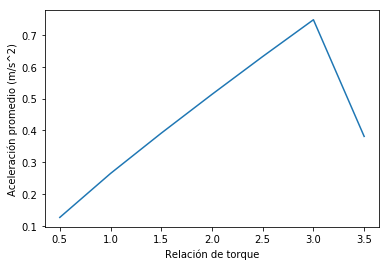

In [10]:
for s in range(len(vector_tm)):    
    
    plt.plot(vector_tm[s],vector_vlts[s], label= vector_ng[s])

    
plt.legend(loc=0 ,title= "Relacion de torque")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (m/s)")
plt.show()

for s in range(len(vector_tm)):  
    
    a = min(len(vector_tm[s]),len(vector_mv[s]))
    
    plt.plot(vector_tm[s][:a],vector_mv[s][:a], label= vector_ng[s])

    
plt.legend(loc=0 ,title= "Relacion de torque")
plt.xlabel("Tiempo (s)")
plt.ylabel("Distancia(m)")
plt.show()

    
    
plt.plot(vector_ng,vector_acl)

plt.xlabel("Relación de torque")
plt.ylabel("Aceleración promedio (m/s^2)")
plt.show()

## Analisis

Se recomienda el uso de una relación de torque de 3. Ya que se observa es la que obtiene el menor tiempo de llegada a la velocidad máxima, sacrificando muy poco la velocidad máxima con respecto a la relación 2.5. Igualmente, en la gráfica de aceleración promedio vs relación de torque, se observa que es la relación con mejor aceleración promedio.

Adicionalmente, se comprueba que se debe tener una relación de potencia y no de velocidad, ya que el caso que uso relacioón de velocidad (0.5) obtuvo el peor desempeño.